In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [15]:
layer_size_list = [2,10,1]
np.random.seed(50)
weight_list = [np.random.normal(0,0.1,(layer_size_list[x]+1,layer_size_list[x+1])) for x in range(len(layer_size_list)-1)]
#weight_list = [np.array([[0.1,0.2],[0.3,0.4]]),np.array([[0.2],[1],[-3]]),np.array([[1],[2]])]
no_of_layers = 3
path = 'D:\Courses\Fall 19\ELEG 815 Statistical Learning\HW6\Dataset'
train_data_all = pd.read_csv(path+'\DigitsTraining.csv',header=None)
test_data_all = pd.read_csv(path+'\DigitsTesting.csv',header=None)
train_data = train_data_all.sample(n=500)
test_data = test_data_all.sample(n=500)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)
#print(train_data)

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
def identity(z):
    return z
def feedforward(datapoint,weight_list):
    prev_layer_activations = datapoint
    signal_list = [0]*(no_of_layers-1)
    activations_list = [0]*no_of_layers
    activations_list[0] = datapoint
    for layer in range(1,no_of_layers):     # l= 2 to L
        WX = np.dot(weight_list[layer-1].T,prev_layer_activations)   
        Z = WX
        signal_list[layer-1] = Z
        if layer == 2:
            activation_Z = identity(Z)
        else:
            activation_Z = tanh(Z)
        x_n = np.empty((activation_Z.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = activation_Z
        activations_list[layer] = x_n
        prev_layer_activations = x_n
    return signal_list,activations_list

In [4]:
def backprop(x,y):
    x_n = np.empty((x.shape[0]+1,))
    x_n[0] = 1
    x_n[1:] = x
    s_l,x_l = feedforward(x_n,weight_list)
    delta_L_tanh = 2 * (x_l[-1][1:] - y) * (1 - x_l[-1][1:]*x_l[-1][1:])
    delta_L_identity = 2 * (x_l[-1][1:] - y)
    deltas_list = [0]*(no_of_layers-1)
    deltas_list[-1] = delta_L_identity
    upstream_gradient = delta_L_identity
    for l in range(no_of_layers-2,0,-1):
        theta_dash_s_l = 1 - x_l[l][1:]*x_l[l][1:]
        delta_l = theta_dash_s_l * np.dot(weight_list[l][1:],upstream_gradient)
        upstream_gradient = delta_l
        deltas_list[l-1] = delta_l
    return deltas_list,x_l

In [5]:
def Extract_features(raw_dataset):
    len_dataset = len(raw_dataset)
    number_of_features = 2
    dataset = np.empty((len_dataset,number_of_features))
    true_labels = np.empty((len_dataset,))
    for index,image_pixels in raw_dataset.iterrows():
        """---------------------- Average Intensity-------------------------"""
        avg_intensity = sum(image_pixels[1:])/len(image_pixels[1:])

        """-----------------------Average Symmetry--------------------------"""
        img = np.array(image_pixels[1:]).reshape((16,16))
        flipped_image = np.fliplr(img)
        flipped_image_pixels = flipped_image.flatten()
        image_pixels = np.array(image_pixels)
        asymmetry = sum(np.absolute(image_pixels[1:] - flipped_image_pixels))/len(image_pixels[1:])
        symmetry = 1 - asymmetry
        dataset[index][0] = 1 - avg_intensity           # Higher value of intensity means there are more white pixels than black pixels because white = 255 and black = 0
        dataset[index][1] = symmetry
        if int(image_pixels[0]) == 1:                   # Suppose digit 1 has label = -1
            true_labels[index] = -1
        else:
            true_labels[index] = 1                      # Suppose all other digits have label = +1
    return dataset,true_labels
d_2_train_dataset,d_2_train_labels = Extract_features(train_data)
d_2_test_dataset,d_2_test_labels = Extract_features(test_data)

In [13]:
print(d_2_train_dataset[0])
#print(weight_list[1])

[0.36908789 0.74448047]


In [7]:
def SGD(weight_list,d_2_train_dataset,d_2_train_labels,learning_rate):
    w = weight_list
    D = d_2_train_dataset
    N = len(D)
    y = d_2_train_labels
    E_in = 0
    g = [0] * (no_of_layers-1)
    for index,d in enumerate(D):
        deltas_list,x_l = backprop(d,y[index])
        E_in += (1/N) * (x_l[-1][1] - y[index])**2
        for l in range(1,no_of_layers):
            delta_T = deltas_list[l-1].reshape((deltas_list[l-1].shape[0],1))
            x_l_previos = x_l[l-1].reshape((x_l[l-1].shape[0],1)) 
            G_l_xn = np.dot(x_l_previos,delta_T.T)
            #g[l-1] += (1/N) * G_l_xn
            weight_list[l-1] -= learning_rate * G_l_xn
    print(E_in)
    return E_in,weight_list

In [8]:
def train_SGD(epochs):
    errors = [0] * epochs
    for epoch in range(epochs):
        print('Epoch :',epoch)
        errors[epoch],weights = SGD(weight_list,d_2_train_dataset,d_2_train_labels,0.01)
    return errors,weight_list
errors_SGD,weight_list_new_SGD = train_SGD(10000)

Epoch : 0
0.5437140951888365
Epoch : 1
0.5212033693505965
Epoch : 2
0.5042567679973178
Epoch : 3
0.4741778342529346
Epoch : 4
0.4307206058392748
Epoch : 5
0.384974000520383
Epoch : 6
0.3511846769254721
Epoch : 7
0.33130630588748095
Epoch : 8
0.3190309906051248
Epoch : 9
0.30978627419573523
Epoch : 10
0.30198804040785293
Epoch : 11
0.29512600561171837
Epoch : 12
0.2889167071484277
Epoch : 13
0.2831885109988731
Epoch : 14
0.27783244991935885
Epoch : 15
0.2727663915661599
Epoch : 16
0.26792629314184147
Epoch : 17
0.263264987239142
Epoch : 18
0.25875016506767917
Epoch : 19
0.2543614451055164
Epoch : 20
0.25008739017709375
Epoch : 21
0.2459228863056952
Epoch : 22
0.24186699952981902
Epoch : 23
0.23792130512969498
Epoch : 24
0.23408863864665522
Epoch : 25
0.2303722035293715
Epoch : 26
0.22677496854205936
Epoch : 27
0.22329929225933182
Epoch : 28
0.21994671902029964
Epoch : 29
0.21671789905228397
Epoch : 30
0.21361259411264394
Epoch : 31
0.2106297382470468
Epoch : 32
0.2077675306653635
Epoch 

0.12421451161626874
Epoch : 267
0.12416436894774714
Epoch : 268
0.12411450302736088
Epoch : 269
0.12406491087129977
Epoch : 270
0.1240155895447626
Epoch : 271
0.12396653616095021
Epoch : 272
0.12391774788008063
Epoch : 273
0.12386922190842493
Epoch : 274
0.12382095549737074
Epoch : 275
0.12377294594250104
Epoch : 276
0.12372519058269985
Epoch : 277
0.12367768679927317
Epoch : 278
0.12363043201509563
Epoch : 279
0.12358342369377222
Epoch : 280
0.12353665933882209
Epoch : 281
0.12349013649287799
Epoch : 282
0.1234438527369088
Epoch : 283
0.12339780568945322
Epoch : 284
0.12335199300587667
Epoch : 285
0.12330641237764207
Epoch : 286
0.12326106153159591
Epoch : 287
0.12321593822927485
Epoch : 288
0.12317104026622283
Epoch : 289
0.12312636547132678
Epoch : 290
0.12308191170616554
Epoch : 291
0.12303767686437436
Epoch : 292
0.12299365887102227
Epoch : 293
0.12294985568200584
Epoch : 294
0.12290626528345237
Epoch : 295
0.12286288569113989
Epoch : 296
0.1228197149499283
Epoch : 297
0.122776751

0.11613981576701769
Epoch : 532
0.11612057531688393
Epoch : 533
0.11610138514477414
Epoch : 534
0.11608224503814414
Epoch : 535
0.11606315478576043
Epoch : 536
0.11604411417769121
Epoch : 537
0.11602512300529276
Epoch : 538
0.11600618106120143
Epoch : 539
0.11598728813932063
Epoch : 540
0.11596844403481164
Epoch : 541
0.11594964854408248
Epoch : 542
0.11593090146477758
Epoch : 543
0.11591220259576837
Epoch : 544
0.11589355173714244
Epoch : 545
0.11587494869019206
Epoch : 546
0.1158563932574075
Epoch : 547
0.11583788524246408
Epoch : 548
0.11581942445021454
Epoch : 549
0.11580101068667854
Epoch : 550
0.11578264375903327
Epoch : 551
0.1157643234756037
Epoch : 552
0.11574604964585361
Epoch : 553
0.1157278220803773
Epoch : 554
0.11570964059088773
Epoch : 555
0.11569150499021133
Epoch : 556
0.11567341509227591
Epoch : 557
0.11565537071210254
Epoch : 558
0.11563737166579825
Epoch : 559
0.11561941777054555
Epoch : 560
0.11560150884459489
Epoch : 561
0.11558364470725607
Epoch : 562
0.115565825

0.11231076308417022
Epoch : 799
0.11230005270168807
Epoch : 800
0.1122893623158761
Epoch : 801
0.11227869186924268
Epoch : 802
0.11226804130452393
Epoch : 803
0.11225741056468425
Epoch : 804
0.11224679959291442
Epoch : 805
0.11223620833263091
Epoch : 806
0.11222563672747388
Epoch : 807
0.11221508472130659
Epoch : 808
0.1122045522582142
Epoch : 809
0.11219403928250338
Epoch : 810
0.11218354573869953
Epoch : 811
0.11217307157154678
Epoch : 812
0.11216261672600641
Epoch : 813
0.11215218114725665
Epoch : 814
0.11214176478069034
Epoch : 815
0.11213136757191401
Epoch : 816
0.11212098946674799
Epoch : 817
0.11211063041122409
Epoch : 818
0.1121002903515851
Epoch : 819
0.11208996923428322
Epoch : 820
0.11207966700597989
Epoch : 821
0.1120693836135434
Epoch : 822
0.11205911900404915
Epoch : 823
0.11204887312477795
Epoch : 824
0.11203864592321466
Epoch : 825
0.11202843734704958
Epoch : 826
0.11201824734417182
Epoch : 827
0.11200807586267547
Epoch : 828
0.11199792285085329
Epoch : 829
0.1119877882

0.1100805252961432
Epoch : 1057
0.11007355472734438
Epoch : 1058
0.11006659454660654
Epoch : 1059
0.11005964473057309
Epoch : 1060
0.11005270525596013
Epoch : 1061
0.11004577609955417
Epoch : 1062
0.11003885723821367
Epoch : 1063
0.110031948648869
Epoch : 1064
0.11002505030851956
Epoch : 1065
0.11001816219423635
Epoch : 1066
0.11001128428316151
Epoch : 1067
0.11000441655250467
Epoch : 1068
0.10999755897954688
Epoch : 1069
0.10999071154163899
Epoch : 1070
0.10998387421619929
Epoch : 1071
0.10997704698071642
Epoch : 1072
0.10997022981274755
Epoch : 1073
0.10996342268991725
Epoch : 1074
0.10995662558991866
Epoch : 1075
0.10994983849051258
Epoch : 1076
0.10994306136952786
Epoch : 1077
0.10993629420486062
Epoch : 1078
0.10992953697447365
Epoch : 1079
0.10992278965639583
Epoch : 1080
0.10991605222872432
Epoch : 1081
0.10990932466962094
Epoch : 1082
0.10990260695731421
Epoch : 1083
0.1098958990700984
Epoch : 1084
0.10988920098633291
Epoch : 1085
0.10988251268444289
Epoch : 1086
0.109875834142

0.10861069723337682
Epoch : 1307
0.10860574551955872
Epoch : 1308
0.10860080003506767
Epoch : 1309
0.10859586076830918
Epoch : 1310
0.10859092770771815
Epoch : 1311
0.10858600084176027
Epoch : 1312
0.10858108015892885
Epoch : 1313
0.1085761656477472
Epoch : 1314
0.1085712572967682
Epoch : 1315
0.10856635509457258
Epoch : 1316
0.10856145902977171
Epoch : 1317
0.10855656909100497
Epoch : 1318
0.10855168526694
Epoch : 1319
0.10854680754627449
Epoch : 1320
0.10854193591773367
Epoch : 1321
0.1085370703700715
Epoch : 1322
0.10853221089207098
Epoch : 1323
0.10852735747254305
Epoch : 1324
0.10852251010032635
Epoch : 1325
0.10851766876428838
Epoch : 1326
0.1085128334533245
Epoch : 1327
0.10850800415635839
Epoch : 1328
0.10850318086234094
Epoch : 1329
0.10849836356025147
Epoch : 1330
0.10849355223909621
Epoch : 1331
0.10848874688791045
Epoch : 1332
0.10848394749575563
Epoch : 1333
0.10847915405172104
Epoch : 1334
0.10847436654492415
Epoch : 1335
0.1084695849645083
Epoch : 1336
0.1084648092996447

Epoch : 1558
0.10753349667766605
Epoch : 1559
0.10752981285092826
Epoch : 1560
0.10752613306454172
Epoch : 1561
0.10752245731209986
Epoch : 1562
0.10751878558721174
Epoch : 1563
0.10751511788349818
Epoch : 1564
0.10751145419459465
Epoch : 1565
0.10750779451415134
Epoch : 1566
0.107504138835831
Epoch : 1567
0.10750048715331123
Epoch : 1568
0.10749683946028189
Epoch : 1569
0.10749319575044723
Epoch : 1570
0.1074895560175254
Epoch : 1571
0.10748592025524803
Epoch : 1572
0.10748228845735977
Epoch : 1573
0.10747866061761895
Epoch : 1574
0.1074750367297972
Epoch : 1575
0.10747141678768025
Epoch : 1576
0.10746780078506649
Epoch : 1577
0.10746418871576874
Epoch : 1578
0.10746058057361081
Epoch : 1579
0.10745697635243268
Epoch : 1580
0.10745337604608557
Epoch : 1581
0.1074497796484334
Epoch : 1582
0.10744618715335642
Epoch : 1583
0.10744259855474504
Epoch : 1584
0.10743901384650302
Epoch : 1585
0.10743543302254854
Epoch : 1586
0.10743185607681088
Epoch : 1587
0.1074282830032357
Epoch : 1588
0.1

0.10672660304702457
Epoch : 1808
0.10672375765149385
Epoch : 1809
0.10672091504944402
Epoch : 1810
0.10671807523700357
Epoch : 1811
0.10671523821030991
Epoch : 1812
0.10671240396550535
Epoch : 1813
0.10670957249874066
Epoch : 1814
0.10670674380617357
Epoch : 1815
0.10670391788396948
Epoch : 1816
0.10670109472830015
Epoch : 1817
0.10669827433534582
Epoch : 1818
0.10669545670129184
Epoch : 1819
0.10669264182233268
Epoch : 1820
0.10668982969466867
Epoch : 1821
0.10668702031450845
Epoch : 1822
0.10668421367806638
Epoch : 1823
0.10668140978156455
Epoch : 1824
0.10667860862123245
Epoch : 1825
0.10667581019330576
Epoch : 1826
0.1066730144940276
Epoch : 1827
0.1066702215196491
Epoch : 1828
0.10666743126642612
Epoch : 1829
0.10666464373062388
Epoch : 1830
0.10666185890851258
Epoch : 1831
0.10665907679637039
Epoch : 1832
0.10665629739048228
Epoch : 1833
0.10665352068714068
Epoch : 1834
0.10665074668264349
Epoch : 1835
0.10664797537329682
Epoch : 1836
0.1066452067554123
Epoch : 1837
0.10664244082

0.10608428018254942
Epoch : 2062
0.10608203696866052
Epoch : 2063
0.1060797957584238
Epoch : 2064
0.10607755654936012
Epoch : 2065
0.10607531933899765
Epoch : 2066
0.10607308412486566
Epoch : 2067
0.10607085090449873
Epoch : 2068
0.10606861967543593
Epoch : 2069
0.1060663904352185
Epoch : 2070
0.10606416318139406
Epoch : 2071
0.10606193791151243
Epoch : 2072
0.10605971462312891
Epoch : 2073
0.10605749331380096
Epoch : 2074
0.10605527398109144
Epoch : 2075
0.10605305662256734
Epoch : 2076
0.10605084123579793
Epoch : 2077
0.10604862781835794
Epoch : 2078
0.10604641636782615
Epoch : 2079
0.10604420688178419
Epoch : 2080
0.10604199935781876
Epoch : 2081
0.10603979379351944
Epoch : 2082
0.10603759018648035
Epoch : 2083
0.10603538853429936
Epoch : 2084
0.10603318883457857
Epoch : 2085
0.10603099108492245
Epoch : 2086
0.10602879528294233
Epoch : 2087
0.10602660142625016
Epoch : 2088
0.10602440951246367
Epoch : 2089
0.10602221953920409
Epoch : 2090
0.1060200315040961
Epoch : 2091
0.10601784540

0.10557823749435566
Epoch : 2313
0.10557642876795222
Epoch : 2314
0.10557462153093425
Epoch : 2315
0.10557281578161805
Epoch : 2316
0.10557101151832127
Epoch : 2317
0.1055692087393641
Epoch : 2318
0.10556740744306937
Epoch : 2319
0.10556560762776271
Epoch : 2320
0.1055638092917704
Epoch : 2321
0.10556201243342352
Epoch : 2322
0.10556021705105394
Epoch : 2323
0.10555842314299611
Epoch : 2324
0.10555663070758786
Epoch : 2325
0.10555483974316836
Epoch : 2326
0.10555305024807939
Epoch : 2327
0.10555126222066517
Epoch : 2328
0.10554947565927228
Epoch : 2329
0.10554769056225037
Epoch : 2330
0.10554590692794982
Epoch : 2331
0.10554412475472491
Epoch : 2332
0.10554234404093178
Epoch : 2333
0.10554056478492932
Epoch : 2334
0.10553878698507717
Epoch : 2335
0.10553701063973885
Epoch : 2336
0.10553523574728015
Epoch : 2337
0.10553346230606914
Epoch : 2338
0.10553169031447533
Epoch : 2339
0.10552991977087128
Epoch : 2340
0.1055281506736315
Epoch : 2341
0.10552638302113343
Epoch : 2342
0.10552461681

0.10516102637345158
Epoch : 2568
0.10515954880087175
Epoch : 2569
0.10515807235569585
Epoch : 2570
0.10515659703673323
Epoch : 2571
0.10515512284279478
Epoch : 2572
0.10515364977269323
Epoch : 2573
0.1051521778252433
Epoch : 2574
0.1051507069992595
Epoch : 2575
0.1051492372935608
Epoch : 2576
0.10514776870696471
Epoch : 2577
0.10514630123829091
Epoch : 2578
0.10514483488636328
Epoch : 2579
0.10514336965000262
Epoch : 2580
0.10514190552803514
Epoch : 2581
0.10514044251928763
Epoch : 2582
0.10513898062258625
Epoch : 2583
0.1051375198367616
Epoch : 2584
0.10513606016064415
Epoch : 2585
0.10513460159306638
Epoch : 2586
0.10513314413286112
Epoch : 2587
0.10513168777886538
Epoch : 2588
0.10513023252991377
Epoch : 2589
0.1051287783848465
Epoch : 2590
0.10512732534250198
Epoch : 2591
0.10512587340172339
Epoch : 2592
0.10512442256135052
Epoch : 2593
0.10512297282022935
Epoch : 2594
0.10512152417720565
Epoch : 2595
0.105120076631126
Epoch : 2596
0.10511863018083895
Epoch : 2597
0.105117184825195

0.10482020073942523
Epoch : 2821
0.10481897415225662
Epoch : 2822
0.1048177484341372
Epoch : 2823
0.10481652358419474
Epoch : 2824
0.10481529960156037
Epoch : 2825
0.10481407648536258
Epoch : 2826
0.10481285423473387
Epoch : 2827
0.10481163284880574
Epoch : 2828
0.10481041232671236
Epoch : 2829
0.10480919266758755
Epoch : 2830
0.10480797387056726
Epoch : 2831
0.10480675593478732
Epoch : 2832
0.10480553885938565
Epoch : 2833
0.10480432264350122
Epoch : 2834
0.10480310728627261
Epoch : 2835
0.10480189278684074
Epoch : 2836
0.10480067914434749
Epoch : 2837
0.10479946635793431
Epoch : 2838
0.10479825442674597
Epoch : 2839
0.10479704334992676
Epoch : 2840
0.10479583312662182
Epoch : 2841
0.10479462375597809
Epoch : 2842
0.10479341523714299
Epoch : 2843
0.10479220756926513
Epoch : 2844
0.10479100075149378
Epoch : 2845
0.10478979478298024
Epoch : 2846
0.10478858966287499
Epoch : 2847
0.10478738539033146
Epoch : 2848
0.10478618196450361
Epoch : 2849
0.10478497938454504
Epoch : 2850
0.104783777

0.1045385129396208
Epoch : 3071
0.1045374789153537
Epoch : 3072
0.10453644557083112
Epoch : 3073
0.10453541290539976
Epoch : 3074
0.1045343809184057
Epoch : 3075
0.10453334960919645
Epoch : 3076
0.10453231897712026
Epoch : 3077
0.10453128902152481
Epoch : 3078
0.10453025974176136
Epoch : 3079
0.10452923113717913
Epoch : 3080
0.1045282032071285
Epoch : 3081
0.10452717595096282
Epoch : 3082
0.10452614936803331
Epoch : 3083
0.10452512345769396
Epoch : 3084
0.10452409821929802
Epoch : 3085
0.10452307365220039
Epoch : 3086
0.10452204975575645
Epoch : 3087
0.10452102652932188
Epoch : 3088
0.10452000397225421
Epoch : 3089
0.10451898208391018
Epoch : 3090
0.1045179608636484
Epoch : 3091
0.10451694031082753
Epoch : 3092
0.10451592042480745
Epoch : 3093
0.10451490120494841
Epoch : 3094
0.10451388265061186
Epoch : 3095
0.10451286476115942
Epoch : 3096
0.10451184753595319
Epoch : 3097
0.1045108309743569
Epoch : 3098
0.10450981507573416
Epoch : 3099
0.10450879983945004
Epoch : 3100
0.10450778526487

0.10429518258893104
Epoch : 3326
0.10429430257355242
Epoch : 3327
0.10429342309260838
Epoch : 3328
0.10429254414560664
Epoch : 3329
0.10429166573205267
Epoch : 3330
0.10429078785145665
Epoch : 3331
0.1042899105033258
Epoch : 3332
0.1042890336871706
Epoch : 3333
0.10428815740249942
Epoch : 3334
0.1042872816488229
Epoch : 3335
0.10428640642565269
Epoch : 3336
0.10428553173249933
Epoch : 3337
0.10428465756887388
Epoch : 3338
0.10428378393428987
Epoch : 3339
0.10428291082826024
Epoch : 3340
0.1042820382502975
Epoch : 3341
0.1042811661999172
Epoch : 3342
0.1042802946766313
Epoch : 3343
0.10427942367995793
Epoch : 3344
0.1042785532094112
Epoch : 3345
0.10427768326450652
Epoch : 3346
0.10427681384476185
Epoch : 3347
0.10427594494969375
Epoch : 3348
0.10427507657881954
Epoch : 3349
0.10427420873165856
Epoch : 3350
0.10427334140772834
Epoch : 3351
0.10427247460654931
Epoch : 3352
0.10427160832764064
Epoch : 3353
0.10427074257052302
Epoch : 3354
0.10426987733471732
Epoch : 3355
0.104269012619744

0.10408910579835359
Epoch : 3578
0.1040883462062376
Epoch : 3579
0.10408758704001864
Epoch : 3580
0.10408682829932464
Epoch : 3581
0.10408606998378063
Epoch : 3582
0.10408531209301615
Epoch : 3583
0.10408455462665875
Epoch : 3584
0.10408379758433617
Epoch : 3585
0.10408304096567708
Epoch : 3586
0.10408228477031163
Epoch : 3587
0.10408152899786813
Epoch : 3588
0.10408077364797721
Epoch : 3589
0.10408001872026956
Epoch : 3590
0.10407926421437572
Epoch : 3591
0.10407851012992696
Epoch : 3592
0.10407775646655383
Epoch : 3593
0.10407700322388999
Epoch : 3594
0.10407625040156689
Epoch : 3595
0.10407549799921813
Epoch : 3596
0.10407474601647637
Epoch : 3597
0.10407399445297488
Epoch : 3598
0.10407324330834905
Epoch : 3599
0.10407249258223229
Epoch : 3600
0.10407174227425922
Epoch : 3601
0.10407099238406585
Epoch : 3602
0.1040702429112877
Epoch : 3603
0.10406949385556093
Epoch : 3604
0.1040687452165219
Epoch : 3605
0.10406799699380766
Epoch : 3606
0.10406724918705564
Epoch : 3607
0.10406650179

0.10390891286447852
Epoch : 3832
0.10390825050177645
Epoch : 3833
0.10390758848233755
Epoch : 3834
0.10390692680588241
Epoch : 3835
0.10390626547212672
Epoch : 3836
0.10390560448079367
Epoch : 3837
0.10390494383160118
Epoch : 3838
0.10390428352426964
Epoch : 3839
0.10390362355851974
Epoch : 3840
0.10390296393407195
Epoch : 3841
0.1039023046506469
Epoch : 3842
0.10390164570796727
Epoch : 3843
0.10390098710575432
Epoch : 3844
0.10390032884372859
Epoch : 3845
0.1038996709216148
Epoch : 3846
0.10389901333913325
Epoch : 3847
0.10389835609600932
Epoch : 3848
0.10389769919196425
Epoch : 3849
0.10389704262672168
Epoch : 3850
0.10389638640000735
Epoch : 3851
0.10389573051154317
Epoch : 3852
0.10389507496105545
Epoch : 3853
0.10389441974826816
Epoch : 3854
0.10389376487290694
Epoch : 3855
0.1038931103346956
Epoch : 3856
0.10389245613336176
Epoch : 3857
0.10389180226863066
Epoch : 3858
0.1038911487402289
Epoch : 3859
0.10389049554788292
Epoch : 3860
0.10388984269131964
Epoch : 3861
0.103889190170

0.10375216167631714
Epoch : 4084
0.10375157770267787
Epoch : 4085
0.10375099401057826
Epoch : 4086
0.10375041059980579
Epoch : 4087
0.10374982747014841
Epoch : 4088
0.10374924462139584
Epoch : 4089
0.1037486620533365
Epoch : 4090
0.10374807976576067
Epoch : 4091
0.10374749775845485
Epoch : 4092
0.1037469160312115
Epoch : 4093
0.10374633458382038
Epoch : 4094
0.10374575341606973
Epoch : 4095
0.10374517252775159
Epoch : 4096
0.1037445919186561
Epoch : 4097
0.10374401158857399
Epoch : 4098
0.1037434315372957
Epoch : 4099
0.10374285176461392
Epoch : 4100
0.10374227227031868
Epoch : 4101
0.10374169305420278
Epoch : 4102
0.103741114116058
Epoch : 4103
0.1037405354556768
Epoch : 4104
0.1037399570728508
Epoch : 4105
0.10373937896737351
Epoch : 4106
0.10373880113903744
Epoch : 4107
0.10373822358763544
Epoch : 4108
0.10373764631296192
Epoch : 4109
0.10373706931480906
Epoch : 4110
0.10373649259297264
Epoch : 4111
0.10373591614724455
Epoch : 4112
0.10373533997742052
Epoch : 4113
0.1037347640832952

0.1036107895090007
Epoch : 4341
0.10361027154015817
Epoch : 4342
0.1036097538054907
Epoch : 4343
0.10360923630483942
Epoch : 4344
0.10360871903804399
Epoch : 4345
0.10360820200494661
Epoch : 4346
0.10360768520538806
Epoch : 4347
0.10360716863920852
Epoch : 4348
0.10360665230625113
Epoch : 4349
0.10360613620635702
Epoch : 4350
0.10360562033936768
Epoch : 4351
0.10360510470512554
Epoch : 4352
0.10360458930347188
Epoch : 4353
0.1036040741342505
Epoch : 4354
0.10360355919730223
Epoch : 4355
0.10360304449247137
Epoch : 4356
0.103602530019599
Epoch : 4357
0.10360201577852958
Epoch : 4358
0.10360150176910589
Epoch : 4359
0.10360098799117093
Epoch : 4360
0.10360047444456931
Epoch : 4361
0.10359996112914328
Epoch : 4362
0.10359944804473767
Epoch : 4363
0.10359893519119585
Epoch : 4364
0.10359842256836264
Epoch : 4365
0.103597910176082
Epoch : 4366
0.10359739801419936
Epoch : 4367
0.10359688608255821
Epoch : 4368
0.1035963743810037
Epoch : 4369
0.10359586290938144
Epoch : 4370
0.1035953516675360

0.1034858838293853
Epoch : 4596
0.10348542084950313
Epoch : 4597
0.1034849580681852
Epoch : 4598
0.10348449548530964
Epoch : 4599
0.10348403310075611
Epoch : 4600
0.10348357091440027
Epoch : 4601
0.10348310892612178
Epoch : 4602
0.10348264713579983
Epoch : 4603
0.10348218554331268
Epoch : 4604
0.10348172414853898
Epoch : 4605
0.10348126295135825
Epoch : 4606
0.10348080195164966
Epoch : 4607
0.1034803411492921
Epoch : 4608
0.10347988054416488
Epoch : 4609
0.10347942013614801
Epoch : 4610
0.10347895992512061
Epoch : 4611
0.1034784999109626
Epoch : 4612
0.10347804009355353
Epoch : 4613
0.10347758047277347
Epoch : 4614
0.10347712104850332
Epoch : 4615
0.10347666182062203
Epoch : 4616
0.10347620278901119
Epoch : 4617
0.10347574395355062
Epoch : 4618
0.10347528531412055
Epoch : 4619
0.10347482687060296
Epoch : 4620
0.1034743686228769
Epoch : 4621
0.10347391057082447
Epoch : 4622
0.10347345271432615
Epoch : 4623
0.10347299505326361
Epoch : 4624
0.10347253758751856
Epoch : 4625
0.1034720803169

0.10337435773593899
Epoch : 4850
0.10337394158363686
Epoch : 4851
0.10337352560251183
Epoch : 4852
0.10337310979246822
Epoch : 4853
0.10337269415341137
Epoch : 4854
0.10337227868524583
Epoch : 4855
0.10337186338787681
Epoch : 4856
0.10337144826120984
Epoch : 4857
0.10337103330515018
Epoch : 4858
0.10337061851960325
Epoch : 4859
0.10337020390447366
Epoch : 4860
0.10336978945966674
Epoch : 4861
0.10336937518508992
Epoch : 4862
0.10336896108064729
Epoch : 4863
0.1033685471462453
Epoch : 4864
0.10336813338178942
Epoch : 4865
0.10336771978718624
Epoch : 4866
0.10336730636234084
Epoch : 4867
0.10336689310715973
Epoch : 4868
0.10336648002155006
Epoch : 4869
0.10336606710541732
Epoch : 4870
0.1033656543586677
Epoch : 4871
0.10336524178120733
Epoch : 4872
0.10336482937294404
Epoch : 4873
0.10336441713378304
Epoch : 4874
0.10336400506363246
Epoch : 4875
0.10336359316239813
Epoch : 4876
0.10336318142998753
Epoch : 4877
0.10336276986630709
Epoch : 4878
0.10336235847126425
Epoch : 4879
0.1033619472

0.10327241109563788
Epoch : 5108
0.10327203618141158
Epoch : 5109
0.10327166141642874
Epoch : 5110
0.10327128680061437
Epoch : 5111
0.10327091233389184
Epoch : 5112
0.10327053801618515
Epoch : 5113
0.10327016384742037
Epoch : 5114
0.10326978982752066
Epoch : 5115
0.10326941595641066
Epoch : 5116
0.10326904223401513
Epoch : 5117
0.10326866866025759
Epoch : 5118
0.10326829523506409
Epoch : 5119
0.10326792195835933
Epoch : 5120
0.10326754883006736
Epoch : 5121
0.10326717585011368
Epoch : 5122
0.10326680301842177
Epoch : 5123
0.10326643033491886
Epoch : 5124
0.10326605779952865
Epoch : 5125
0.1032656854121754
Epoch : 5126
0.10326531317278577
Epoch : 5127
0.10326494108128527
Epoch : 5128
0.10326456913759786
Epoch : 5129
0.10326419734164914
Epoch : 5130
0.10326382569336534
Epoch : 5131
0.10326345419267141
Epoch : 5132
0.10326308283949266
Epoch : 5133
0.10326271163375504
Epoch : 5134
0.10326234057538423
Epoch : 5135
0.10326196966430613
Epoch : 5136
0.10326159890044566
Epoch : 5137
0.103261228

0.10318076617610523
Epoch : 5365
0.10318042728665842
Epoch : 5366
0.10318008852884519
Epoch : 5367
0.10317974990260344
Epoch : 5368
0.10317941140787219
Epoch : 5369
0.10317907304458766
Epoch : 5370
0.10317873481268948
Epoch : 5371
0.10317839671211594
Epoch : 5372
0.10317805874280557
Epoch : 5373
0.10317772090469658
Epoch : 5374
0.10317738319772561
Epoch : 5375
0.10317704562183477
Epoch : 5376
0.10317670817695927
Epoch : 5377
0.10317637086303959
Epoch : 5378
0.10317603368001393
Epoch : 5379
0.10317569662782089
Epoch : 5380
0.10317535970639834
Epoch : 5381
0.1031750229156864
Epoch : 5382
0.10317468625562366
Epoch : 5383
0.10317434972614806
Epoch : 5384
0.10317401332719958
Epoch : 5385
0.10317367705871634
Epoch : 5386
0.10317334092063805
Epoch : 5387
0.10317300491290333
Epoch : 5388
0.10317266903545068
Epoch : 5389
0.10317233328822109
Epoch : 5390
0.10317199767115211
Epoch : 5391
0.10317166218418314
Epoch : 5392
0.10317132682725426
Epoch : 5393
0.10317099160030388
Epoch : 5394
0.103170656

0.10309845088404478
Epoch : 5620
0.10309814367562498
Epoch : 5621
0.10309783658443251
Epoch : 5622
0.10309752961041459
Epoch : 5623
0.10309722275352139
Epoch : 5624
0.10309691601369943
Epoch : 5625
0.10309660939089858
Epoch : 5626
0.1030963028850661
Epoch : 5627
0.10309599649615243
Epoch : 5628
0.1030956902241056
Epoch : 5629
0.10309538406887334
Epoch : 5630
0.10309507803040521
Epoch : 5631
0.1030947721086502
Epoch : 5632
0.10309446630355615
Epoch : 5633
0.10309416061507305
Epoch : 5634
0.10309385504314851
Epoch : 5635
0.10309354958773237
Epoch : 5636
0.10309324424877334
Epoch : 5637
0.10309293902622069
Epoch : 5638
0.10309263392002238
Epoch : 5639
0.10309232893012862
Epoch : 5640
0.10309202405648729
Epoch : 5641
0.10309171929904895
Epoch : 5642
0.10309141465776171
Epoch : 5643
0.10309111013257491
Epoch : 5644
0.10309080572343794
Epoch : 5645
0.10309050143029984
Epoch : 5646
0.10309019725311022
Epoch : 5647
0.10308989319181729
Epoch : 5648
0.10308958924637263
Epoch : 5649
0.10308928541

0.1030237740648617
Epoch : 5875
0.10302349516971344
Epoch : 5876
0.10302321637969163
Epoch : 5877
0.1030229376947526
Epoch : 5878
0.10302265911485367
Epoch : 5879
0.10302238063995009
Epoch : 5880
0.10302210226999908
Epoch : 5881
0.10302182400495616
Epoch : 5882
0.10302154584477875
Epoch : 5883
0.10302126778942271
Epoch : 5884
0.10302098983884525
Epoch : 5885
0.10302071199300193
Epoch : 5886
0.1030204342518501
Epoch : 5887
0.10302015661534657
Epoch : 5888
0.10301987908344767
Epoch : 5889
0.10301960165610938
Epoch : 5890
0.10301932433328967
Epoch : 5891
0.10301904711494476
Epoch : 5892
0.1030187700010315
Epoch : 5893
0.10301849299150571
Epoch : 5894
0.10301821608632586
Epoch : 5895
0.1030179392854469
Epoch : 5896
0.1030176625888278
Epoch : 5897
0.10301738599642495
Epoch : 5898
0.103017109508193
Epoch : 5899
0.10301683312409153
Epoch : 5900
0.10301655684407689
Epoch : 5901
0.10301628066810549
Epoch : 5902
0.10301600459613475
Epoch : 5903
0.1030157286281219
Epoch : 5904
0.10301545276402349

0.10295594561483484
Epoch : 6130
0.1029556921839795
Epoch : 6131
0.10295543884794009
Epoch : 6132
0.10295518560668135
Epoch : 6133
0.1029549324601641
Epoch : 6134
0.10295467940835204
Epoch : 6135
0.10295442645120717
Epoch : 6136
0.10295417358869269
Epoch : 6137
0.10295392082077152
Epoch : 6138
0.10295366814740545
Epoch : 6139
0.10295341556855797
Epoch : 6140
0.10295316308419092
Epoch : 6141
0.10295291069426843
Epoch : 6142
0.1029526583987523
Epoch : 6143
0.10295240619760576
Epoch : 6144
0.10295215409079053
Epoch : 6145
0.10295190207827166
Epoch : 6146
0.10295165016001022
Epoch : 6147
0.10295139833596953
Epoch : 6148
0.10295114660611304
Epoch : 6149
0.1029508949704027
Epoch : 6150
0.10295064342880246
Epoch : 6151
0.10295039198127537
Epoch : 6152
0.10295014062778332
Epoch : 6153
0.10294988936828983
Epoch : 6154
0.10294963820275865
Epoch : 6155
0.10294938713115252
Epoch : 6156
0.1029491361534338
Epoch : 6157
0.10294888526956646
Epoch : 6158
0.10294863447951229
Epoch : 6159
0.1029483837832

0.10289544609798322
Epoch : 6380
0.10289521525959461
Epoch : 6381
0.10289498450729861
Epoch : 6382
0.10289475384106067
Epoch : 6383
0.10289452326085023
Epoch : 6384
0.1028942927666338
Epoch : 6385
0.10289406235837882
Epoch : 6386
0.1028938320360525
Epoch : 6387
0.10289360179962258
Epoch : 6388
0.10289337164905842
Epoch : 6389
0.10289314158432444
Epoch : 6390
0.10289291160539103
Epoch : 6391
0.10289268171222458
Epoch : 6392
0.10289245190479306
Epoch : 6393
0.10289222218306363
Epoch : 6394
0.10289199254700418
Epoch : 6395
0.10289176299658266
Epoch : 6396
0.10289153353176654
Epoch : 6397
0.10289130415252322
Epoch : 6398
0.10289107485882208
Epoch : 6399
0.10289084565062889
Epoch : 6400
0.10289061652791275
Epoch : 6401
0.10289038749063999
Epoch : 6402
0.10289015853877964
Epoch : 6403
0.10288992967230001
Epoch : 6404
0.10288970089116795
Epoch : 6405
0.10288947219535143
Epoch : 6406
0.10288924358481834
Epoch : 6407
0.1028890150595372
Epoch : 6408
0.10288878661947518
Epoch : 6409
0.10288855826

0.10283844534708027
Epoch : 6639
0.10283823576738142
Epoch : 6640
0.1028380262658983
Epoch : 6641
0.10283781684260089
Epoch : 6642
0.10283760749746185
Epoch : 6643
0.102837398230453
Epoch : 6644
0.10283718904154529
Epoch : 6645
0.10283697993071039
Epoch : 6646
0.10283677089792063
Epoch : 6647
0.10283656194314739
Epoch : 6648
0.10283635306636181
Epoch : 6649
0.10283614426753535
Epoch : 6650
0.10283593554664151
Epoch : 6651
0.10283572690365023
Epoch : 6652
0.10283551833853366
Epoch : 6653
0.10283530985126384
Epoch : 6654
0.1028351014418127
Epoch : 6655
0.102834893110152
Epoch : 6656
0.1028346848562527
Epoch : 6657
0.10283447668008748
Epoch : 6658
0.1028342685816275
Epoch : 6659
0.10283406056084575
Epoch : 6660
0.10283385261771247
Epoch : 6661
0.10283364475220075
Epoch : 6662
0.102833436964282
Epoch : 6663
0.10283322925392793
Epoch : 6664
0.10283302162111047
Epoch : 6665
0.10283281406580178
Epoch : 6666
0.10283260658797407
Epoch : 6667
0.10283239918759923
Epoch : 6668
0.10283219186464851


0.10278726972825315
Epoch : 6895
0.10278707928131157
Epoch : 6896
0.1027868889057432
Epoch : 6897
0.10278669860152262
Epoch : 6898
0.1027865083686249
Epoch : 6899
0.10278631820702548
Epoch : 6900
0.1027861281166979
Epoch : 6901
0.10278593809761949
Epoch : 6902
0.10278574814976268
Epoch : 6903
0.10278555827310419
Epoch : 6904
0.10278536846761759
Epoch : 6905
0.10278517873327873
Epoch : 6906
0.1027849890700616
Epoch : 6907
0.10278479947794236
Epoch : 6908
0.10278460995689565
Epoch : 6909
0.1027844205068964
Epoch : 6910
0.1027842311279196
Epoch : 6911
0.10278404181993994
Epoch : 6912
0.10278385258293365
Epoch : 6913
0.1027836634168738
Epoch : 6914
0.10278347432173693
Epoch : 6915
0.10278328529749789
Epoch : 6916
0.10278309634413166
Epoch : 6917
0.10278290746161288
Epoch : 6918
0.10278271864991734
Epoch : 6919
0.10278252990902013
Epoch : 6920
0.10278234123889603
Epoch : 6921
0.10278215263951969
Epoch : 6922
0.10278196411086772
Epoch : 6923
0.10278177565291403
Epoch : 6924
0.102781587265634

0.10274077741355409
Epoch : 7151
0.10274060444808951
Epoch : 7152
0.10274043154791448
Epoch : 7153
0.10274025871300718
Epoch : 7154
0.10274008594334527
Epoch : 7155
0.10273991323890656
Epoch : 7156
0.10273974059966848
Epoch : 7157
0.10273956802560798
Epoch : 7158
0.10273939551670286
Epoch : 7159
0.10273922307293101
Epoch : 7160
0.10273905069426993
Epoch : 7161
0.1027388783806974
Epoch : 7162
0.10273870613219098
Epoch : 7163
0.10273853394872795
Epoch : 7164
0.10273836183028541
Epoch : 7165
0.10273818977684306
Epoch : 7166
0.10273801778837584
Epoch : 7167
0.1027378458648633
Epoch : 7168
0.10273767400628293
Epoch : 7169
0.10273750221261159
Epoch : 7170
0.10273733048382742
Epoch : 7171
0.10273715881990847
Epoch : 7172
0.10273698722083124
Epoch : 7173
0.10273681568657478
Epoch : 7174
0.1027366442171162
Epoch : 7175
0.10273647281243292
Epoch : 7176
0.10273630147250394
Epoch : 7177
0.1027361301973047
Epoch : 7178
0.10273595898681538
Epoch : 7179
0.10273578784101224
Epoch : 7180
0.102735616759

0.1026982549027393
Epoch : 7409
0.10269809806178651
Epoch : 7410
0.10269794128060919
Epoch : 7411
0.10269778455918938
Epoch : 7412
0.10269762789750463
Epoch : 7413
0.10269747129553483
Epoch : 7414
0.10269731475326059
Epoch : 7415
0.10269715827066069
Epoch : 7416
0.1026970018477155
Epoch : 7417
0.1026968454844049
Epoch : 7418
0.1026966891807069
Epoch : 7419
0.1026965329366036
Epoch : 7420
0.102696376752073
Epoch : 7421
0.10269622062709588
Epoch : 7422
0.10269606456165095
Epoch : 7423
0.10269590855571945
Epoch : 7424
0.10269575260927928
Epoch : 7425
0.10269559672231186
Epoch : 7426
0.10269544089479543
Epoch : 7427
0.10269528512671132
Epoch : 7428
0.10269512941803795
Epoch : 7429
0.1026949737687557
Epoch : 7430
0.10269481817884502
Epoch : 7431
0.1026946626482852
Epoch : 7432
0.10269450717705508
Epoch : 7433
0.10269435176513518
Epoch : 7434
0.10269419641250678
Epoch : 7435
0.10269404111914762
Epoch : 7436
0.10269388588503861
Epoch : 7437
0.10269373071015912
Epoch : 7438
0.1026935755944892


0.10265971542147373
Epoch : 7667
0.10265957334805949
Epoch : 7668
0.10265943132939856
Epoch : 7669
0.10265928936547374
Epoch : 7670
0.10265914745626407
Epoch : 7671
0.10265900560175277
Epoch : 7672
0.10265886380191994
Epoch : 7673
0.10265872205674753
Epoch : 7674
0.10265858036621743
Epoch : 7675
0.10265843873030972
Epoch : 7676
0.10265829714900683
Epoch : 7677
0.10265815562228985
Epoch : 7678
0.10265801415014024
Epoch : 7679
0.10265787273253921
Epoch : 7680
0.1026577313694685
Epoch : 7681
0.10265759006090856
Epoch : 7682
0.10265744880684262
Epoch : 7683
0.10265730760725045
Epoch : 7684
0.10265716646211391
Epoch : 7685
0.1026570253714149
Epoch : 7686
0.10265688433513438
Epoch : 7687
0.10265674335325453
Epoch : 7688
0.10265660242575543
Epoch : 7689
0.10265646155261979
Epoch : 7690
0.10265632073382822
Epoch : 7691
0.10265617996936253
Epoch : 7692
0.10265603925920536
Epoch : 7693
0.10265589860333547
Epoch : 7694
0.10265575800173683
Epoch : 7695
0.10265561745439063
Epoch : 7696
0.1026554769

0.10262585414548991
Epoch : 7917
0.10262572519380188
Epoch : 7918
0.1026255962923694
Epoch : 7919
0.10262546744117512
Epoch : 7920
0.10262533864020142
Epoch : 7921
0.10262520988943248
Epoch : 7922
0.1026250811888487
Epoch : 7923
0.10262495253843501
Epoch : 7924
0.10262482393817172
Epoch : 7925
0.10262469538804343
Epoch : 7926
0.10262456688803222
Epoch : 7927
0.10262443843812036
Epoch : 7928
0.10262431003829092
Epoch : 7929
0.1026241816885263
Epoch : 7930
0.1026240533888092
Epoch : 7931
0.1026239251391224
Epoch : 7932
0.10262379693944851
Epoch : 7933
0.10262366878977103
Epoch : 7934
0.10262354069007162
Epoch : 7935
0.10262341264033294
Epoch : 7936
0.10262328464053828
Epoch : 7937
0.10262315669067039
Epoch : 7938
0.10262302879071118
Epoch : 7939
0.10262290094064373
Epoch : 7940
0.10262277314045187
Epoch : 7941
0.1026226453901174
Epoch : 7942
0.10262251768962284
Epoch : 7943
0.1026223900389509
Epoch : 7944
0.1026222624380842
Epoch : 7945
0.10262213488700644
Epoch : 7946
0.1026220073856995

0.1025947858242397
Epoch : 8170
0.10259466904511012
Epoch : 8171
0.10259455231197756
Epoch : 8172
0.10259443562482572
Epoch : 8173
0.10259431898363862
Epoch : 8174
0.10259420238839899
Epoch : 8175
0.10259408583909187
Epoch : 8176
0.10259396933570035
Epoch : 8177
0.10259385287820758
Epoch : 8178
0.10259373646659765
Epoch : 8179
0.1025936201008552
Epoch : 8180
0.10259350378096223
Epoch : 8181
0.10259338750690383
Epoch : 8182
0.10259327127866297
Epoch : 8183
0.10259315509622355
Epoch : 8184
0.10259303895956969
Epoch : 8185
0.10259292286868402
Epoch : 8186
0.10259280682355185
Epoch : 8187
0.10259269082415536
Epoch : 8188
0.10259257487047921
Epoch : 8189
0.10259245896250717
Epoch : 8190
0.10259234310022254
Epoch : 8191
0.10259222728360912
Epoch : 8192
0.10259211151265071
Epoch : 8193
0.10259199578733105
Epoch : 8194
0.10259188010763401
Epoch : 8195
0.10259176447354398
Epoch : 8196
0.10259164888504325
Epoch : 8197
0.10259153334211664
Epoch : 8198
0.10259141784474751
Epoch : 8199
0.1025913023

0.10256698127046716
Epoch : 8420
0.10256687549171167
Epoch : 8421
0.10256676975498201
Epoch : 8422
0.10256666406026287
Epoch : 8423
0.10256655840753849
Epoch : 8424
0.10256645279679417
Epoch : 8425
0.10256634722801387
Epoch : 8426
0.10256624170118295
Epoch : 8427
0.10256613621628481
Epoch : 8428
0.10256603077330441
Epoch : 8429
0.1025659253722274
Epoch : 8430
0.10256582001303675
Epoch : 8431
0.10256571469571728
Epoch : 8432
0.10256560942025439
Epoch : 8433
0.10256550418663209
Epoch : 8434
0.10256539899483545
Epoch : 8435
0.1025652938448483
Epoch : 8436
0.10256518873665599
Epoch : 8437
0.10256508367024282
Epoch : 8438
0.10256497864559307
Epoch : 8439
0.1025648736626916
Epoch : 8440
0.10256476872152312
Epoch : 8441
0.10256466382207206
Epoch : 8442
0.10256455896432325
Epoch : 8443
0.10256445414826094
Epoch : 8444
0.10256434937387018
Epoch : 8445
0.10256424464113495
Epoch : 8446
0.10256413995004109
Epoch : 8447
0.10256403530057195
Epoch : 8448
0.10256393069271186
Epoch : 8449
0.10256382612

0.10254151825395251
Epoch : 8673
0.1025414226234941
Epoch : 8674
0.1025413270312519
Epoch : 8675
0.10254123147721118
Epoch : 8676
0.102541135961357
Epoch : 8677
0.10254104048367492
Epoch : 8678
0.102540945044151
Epoch : 8679
0.1025408496427694
Epoch : 8680
0.10254075427951663
Epoch : 8681
0.10254065895437678
Epoch : 8682
0.10254056366733608
Epoch : 8683
0.10254046841837952
Epoch : 8684
0.10254037320749228
Epoch : 8685
0.10254027803466063
Epoch : 8686
0.10254018289986902
Epoch : 8687
0.10254008780310307
Epoch : 8688
0.10253999274434866
Epoch : 8689
0.10253989772359068
Epoch : 8690
0.10253980274081456
Epoch : 8691
0.10253970779600613
Epoch : 8692
0.10253961288914981
Epoch : 8693
0.10253951802023199
Epoch : 8694
0.10253942318923695
Epoch : 8695
0.10253932839615168
Epoch : 8696
0.10253923364095949
Epoch : 8697
0.10253913892364785
Epoch : 8698
0.10253904424420149
Epoch : 8699
0.10253894960260498
Epoch : 8700
0.10253885499884463
Epoch : 8701
0.10253876043290697
Epoch : 8702
0.102538665904773

0.10251833060303826
Epoch : 8928
0.10251824425129584
Epoch : 8929
0.1025181579341316
Epoch : 8930
0.1025180716515305
Epoch : 8931
0.10251798540347916
Epoch : 8932
0.10251789918996379
Epoch : 8933
0.10251781301097099
Epoch : 8934
0.10251772686648633
Epoch : 8935
0.10251764075649607
Epoch : 8936
0.10251755468098582
Epoch : 8937
0.1025174686399424
Epoch : 8938
0.10251738263335193
Epoch : 8939
0.10251729666119985
Epoch : 8940
0.10251721072347364
Epoch : 8941
0.10251712482015818
Epoch : 8942
0.10251703895124131
Epoch : 8943
0.10251695311670703
Epoch : 8944
0.10251686731654307
Epoch : 8945
0.10251678155073504
Epoch : 8946
0.10251669581926881
Epoch : 8947
0.1025166101221313
Epoch : 8948
0.1025165244593085
Epoch : 8949
0.10251643883078619
Epoch : 8950
0.10251635323655141
Epoch : 8951
0.10251626767658918
Epoch : 8952
0.1025161821508862
Epoch : 8953
0.10251609665942828
Epoch : 8954
0.1025160112022037
Epoch : 8955
0.10251592577919497
Epoch : 8956
0.1025158403903924
Epoch : 8957
0.1025157550357788

0.10249770558663901
Epoch : 9179
0.10249762748709108
Epoch : 9180
0.10249754941873972
Epoch : 9181
0.10249747138157385
Epoch : 9182
0.10249739337557966
Epoch : 9183
0.10249731540074408
Epoch : 9184
0.10249723745705404
Epoch : 9185
0.10249715954449687
Epoch : 9186
0.10249708166305949
Epoch : 9187
0.10249700381272783
Epoch : 9188
0.10249692599349121
Epoch : 9189
0.10249684820533408
Epoch : 9190
0.10249677044824422
Epoch : 9191
0.10249669272221013
Epoch : 9192
0.10249661502721631
Epoch : 9193
0.1024965373632516
Epoch : 9194
0.10249645973030161
Epoch : 9195
0.10249638212835475
Epoch : 9196
0.10249630455739707
Epoch : 9197
0.10249622701741658
Epoch : 9198
0.10249614950839907
Epoch : 9199
0.10249607203033216
Epoch : 9200
0.10249599458320283
Epoch : 9201
0.10249591716699827
Epoch : 9202
0.10249583978170476
Epoch : 9203
0.10249576242730991
Epoch : 9204
0.1024956851038003
Epoch : 9205
0.10249560781116401
Epoch : 9206
0.10249553054938759
Epoch : 9207
0.10249545331845776
Epoch : 9208
0.1024953761

0.10247890669791845
Epoch : 9432
0.10247883608468182
Epoch : 9433
0.10247876549945305
Epoch : 9434
0.102478694942219
Epoch : 9435
0.10247862441296815
Epoch : 9436
0.10247855391168789
Epoch : 9437
0.10247848343836749
Epoch : 9438
0.102478412992993
Epoch : 9439
0.1024783425755526
Epoch : 9440
0.10247827218603545
Epoch : 9441
0.10247820182442768
Epoch : 9442
0.10247813149071831
Epoch : 9443
0.10247806118489543
Epoch : 9444
0.10247799090694555
Epoch : 9445
0.1024779206568583
Epoch : 9446
0.10247785043461968
Epoch : 9447
0.10247778024021914
Epoch : 9448
0.1024777100736443
Epoch : 9449
0.10247763993488236
Epoch : 9450
0.10247756982392131
Epoch : 9451
0.10247749974074977
Epoch : 9452
0.1024774296853551
Epoch : 9453
0.10247735965772609
Epoch : 9454
0.10247728965784861
Epoch : 9455
0.1024772196857129
Epoch : 9456
0.10247714974130552
Epoch : 9457
0.10247707982461475
Epoch : 9458
0.10247700993562887
Epoch : 9459
0.10247694007433464
Epoch : 9460
0.10247687024072154
Epoch : 9461
0.10247680043477682

0.10246177477207709
Epoch : 9687
0.10246171091710495
Epoch : 9688
0.1024616470871614
Epoch : 9689
0.10246158328223369
Epoch : 9690
0.1024615195023117
Epoch : 9691
0.10246145574738391
Epoch : 9692
0.10246139201743805
Epoch : 9693
0.10246132831246484
Epoch : 9694
0.10246126463245243
Epoch : 9695
0.10246120097738877
Epoch : 9696
0.10246113734726355
Epoch : 9697
0.10246107374206563
Epoch : 9698
0.10246101016178367
Epoch : 9699
0.10246094660640599
Epoch : 9700
0.10246088307592169
Epoch : 9701
0.10246081957032094
Epoch : 9702
0.10246075608959025
Epoch : 9703
0.10246069263372004
Epoch : 9704
0.10246062920269856
Epoch : 9705
0.10246056579651612
Epoch : 9706
0.10246050241515905
Epoch : 9707
0.10246043905861803
Epoch : 9708
0.10246037572688213
Epoch : 9709
0.10246031241993837
Epoch : 9710
0.10246024913777774
Epoch : 9711
0.102460185880388
Epoch : 9712
0.10246012264775778
Epoch : 9713
0.10246005943987661
Epoch : 9714
0.10245999625673397
Epoch : 9715
0.10245993309831733
Epoch : 9716
0.102459869964

0.10244650388402239
Epoch : 9938
0.1024464459698011
Epoch : 9939
0.10244638807791884
Epoch : 9940
0.10244633020836658
Epoch : 9941
0.10244627236113325
Epoch : 9942
0.1024462145362079
Epoch : 9943
0.10244615673358205
Epoch : 9944
0.1024460989532447
Epoch : 9945
0.10244604119518615
Epoch : 9946
0.1024459834593953
Epoch : 9947
0.10244592574586216
Epoch : 9948
0.10244586805457698
Epoch : 9949
0.10244581038552976
Epoch : 9950
0.10244575273870989
Epoch : 9951
0.10244569511410714
Epoch : 9952
0.10244563751171076
Epoch : 9953
0.10244557993151222
Epoch : 9954
0.10244552237350027
Epoch : 9955
0.10244546483766491
Epoch : 9956
0.10244540732399597
Epoch : 9957
0.10244534983248392
Epoch : 9958
0.10244529236311768
Epoch : 9959
0.10244523491588745
Epoch : 9960
0.10244517749078336
Epoch : 9961
0.10244512008779462
Epoch : 9962
0.10244506270691138
Epoch : 9963
0.10244500534812488
Epoch : 9964
0.10244494801142262
Epoch : 9965
0.10244489069679619
Epoch : 9966
0.10244483340423474
Epoch : 9967
0.102444776133

Text(0,0.5,'Error')

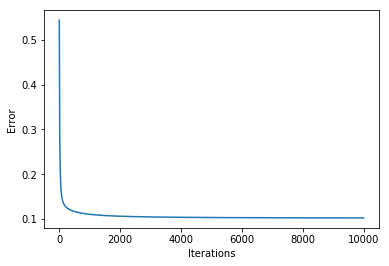

In [9]:
plt.plot(errors_SGD)
plt.xlabel('Iterations')
plt.ylabel('Error')

In [10]:
def evaluate(test_data,test_labels,weight_list_new):
    cnt = 0
    for index,x in enumerate(test_data):
        x_n = np.empty((x.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = x
        x_l = feedforward(x_n,weight_list)[1]
        #print(x_l[-1][1])
        if x_l[-1][1] > 0 and test_labels[index] == 1:
            cnt += 1
        if x_l[-1][1] < 0 and test_labels[index] == -1:
            cnt += 1
    return cnt
cnt = evaluate(d_2_test_dataset,d_2_test_labels,weight_list_new_SGD)

print(cnt)
print((cnt/len(d_2_test_dataset))*100)

486
97.2


Text(0,0.5,'log10(Error)')

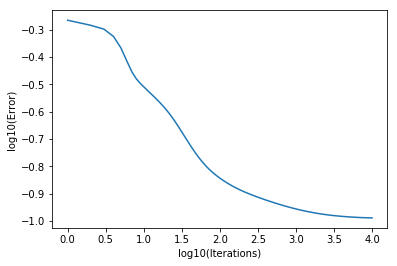

In [11]:
iters = [i for i in range(1,10001)]
plt.plot(np.log10(iters),np.log10(errors_SGD))
plt.xlabel('log10(Iterations)')
plt.ylabel('log10(Error)')